# Anomaly detection in GPU data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import time
%load_ext autoreload
%autoreload 2

## Data processing

In [ ]:
with open('functimes_combined.dat', "r") as f:
    raw_data = [x.strip("\n").split() for x in f.readlines()]

run_time = {}
for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): # get the func name
            func_name.append(i[j])
        else:
            runtime = [int(x) for x in i[j:]]
            key = "_".join(func_name).strip('\"')
            # if a key already exists, then the new runtime list will append to the existing list
            value = run_time.get(key)
            if value == None:
                run_time[key] = runtime
            else:
                run_time[key] = value.append(runtime)
    
            break # exit the loop once we find the position of the first numeric element

We see that the length of` (run_time)` isn't equal to the raw data

In [ ]:
len(run_time), len(raw_data)

We can collect the function name and check if anything is wrong:

In [ ]:
fun_name = []

for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): 
            func_name.append(i[j]) # get the func name
    key = "_".join(func_name).strip('\"')
    fun_name.append(key)

In [ ]:
for name, i in zip(fun_name, range(len(fun_name))):
    try:
        run_time[name]
    except:
        print(name, i)

If we check the original data file we will notice this is really the case. No runtime data follows `TOTAL`. And their is a blank entry in line 354.

Next let's select the most frequently called functions:

In [ ]:
len_list = []
for key, value in run_time.items():
    len_list.append(len(run_time[key]))

df_len = pd.DataFrame(len_list, index=run_time.keys())
df_len = df_len.reset_index()
df_len = df_len.rename(columns={"index": 'func_name', 0:'call_times'})
df_len = df_len.sort_values('call_times', ascending = False)

In [ ]:
min_call_times = 10000
df_freq = df_len[df_len['call_times'] > min_call_times]
subset = df_freq.sample(frac = 0.7, random_state = 2)

In [33]:
def sample_portion(dic, func, frac = 0.3):    
    func_runtime = dic[func]
    # total length of the sample
    length = int(len(func_runtime) * frac)
    # select where to start taking the data
    start_position = np.random.randint(0, (len(func_runtime) - length))
    sample_runtime = func_runtime[start_position : start_position + length]
    df_sample = pd.DataFrame({'run_time' : sample_runtime})
    df_sample.name = func
    
    return df_sample   

In [ ]:
i = np.random.randint(len(subset))
func_name = subset.iloc[i].func_name
sample = sample_portion(run_time, func_name)

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set_style("darkgrid")
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = [13, 5.]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['legend.frameon'] = True

In [32]:
def plot_result(outlier, normal, method, *args):
    total_points = len(outlier) + len(normal)
    ratio = len(outlier) / total_points
    para = args
    plt.figure()
    if ratio >= 0.01:
        plt.title("{}, outlier_ratio={:.2f}".format(method, ratio))
    else:
        plt.title("{}, {} outliers in {} points".format(method, len(outlier), total_points))
    g = plt.scatter(normal.index,  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier.index, outlier['run_time'], c='red', s=55, edgecolor='k')
    plt.ylabel('run_time')
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 15})
    plt.show()

## Moving Gaussian

In [102]:
def moving_gaussian(df, window_frac = 0.2, c = 6, enforce=False, cut_off=10, plot = True):
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    else:
        x_ = df.run_time.values
        highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25)
        
        if (highest - low) / low <= cut_off and enforce:
            out, normal = pd.DataFrame({'run_time':[]}), df
            print("cutoff rule applied with cutoff={}".format(cut_off))
        else:
            window = int(window_frac * len(df))
            mean = df.run_time.rolling(window = window).mean()
            mean.iloc[:(window-1)] = mean.iloc[window]
            std = df.run_time.rolling(window = window).std()
            std.iloc[:(window-1)] = std.iloc[window]

            upper = mean + c * std
            lower = mean - c * std
            a1 = df.run_time > upper
            a2 = df.run_time < lower

            anomalies = np.logical_or(a1, a2)
            normal = np.logical_not(anomalies)
            outlier = df[anomalies]
            normal = df[normal]

    if plot:
        plot_result(outlier, normal, 'Gaussian')    
    return outlier, normal

In [ ]:
out, normal = moving_gaussian(sample, plot=False);

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i+92)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    #print(j, func_name)
    sample = sample_portion(run_time, func_name)
    moving_gaussian(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Moving Quantile Range

In [ ]:
def moving_quantile(df, window_frac = 0.2, c = 6, cut_off = 20, q_low = 0.1, q_high = 0.9, plot=True):
    x_ = df.run_time.values.reshape(-1, 1)
    highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25)
    
    if df.run_time.std() == 0:
        outlier, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    
    elif (highest - low)/low <= cut_off:
        outlier, normal = pd.DataFrame({'run_time':[]}), df
        print("cutoff rule applied with cutoff={}".format(cut_off))

    else:  
        if (high - low)/low < 0.5: # if majority of the data is narrowly distributed, lower the outlier ratio
            c = 2 * c
            q_low, q_high = 0.1 * q_low, 0.1 * q_high
            print('threshold increased to c={}'.format(c))
        
        window = int(window_frac * len(df))
        q1 = df.run_time.rolling(window = window).quantile(q_low)
        q3 = df.run_time.rolling(window = window).quantile(q_high)
        q1.iloc[:(window-1)] = q1.iloc[window]
        q3.iloc[:(window-1)] = q3.iloc[window]

        upper = q3 + c * (q3 - q1)
        lower = q1 - c * (q3 - q1)
        a1 = df.run_time > upper
        a2 = df.run_time < lower
        
        anomalies = np.logical_or(a1, a2)
        normal = np.logical_not(anomalies)
        outlier = df[anomalies]
        normal = df[normal]
    
    if plot:
        plot_result(outlier, normal, 'Tukey')        
    return outlier, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i+92)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name, frac=0.8)
    moving_quantile(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## MinClusterDetector

`MinClusterDetector` treats multivariate time series as independent points in a high-dimensional space, divides them into clusters, and identifies values in the smallest cluster as anomalous. This may help capturing outliers in high-dimensional space.

In [ ]:
from adtk.data import validate_series

def transform_adtk(df):
    tmp = pd.to_datetime(df.index.values, unit='s',
               origin=pd.Timestamp('2020-01-01'))
    idx = pd.Index(tmp, name='timestamp')
    
    data = {'run_time': df['run_time'].values}
    df_trans = pd.DataFrame(data=data, index=idx)
    df_trans.name = df.name
    return df_trans

def inverse_transform_adtk(df):
    idx = (df.index - pd.Timestamp("2020-01-01")) // pd.Timedelta('1s')
    data = {'run_time': df['run_time'].values}
    df_inverse = pd.DataFrame(data=data, index=idx)
    return df_inverse

In [ ]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans

def min_cluster(df, n_clusters = 2, cut_off = 10, plot=True, enforce=True):
    eps = 1e-7
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    else:
        x_ = df.run_time.values
        highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25) + eps
        
        if (highest - low) / low <= cut_off and enforce:
            out, normal = pd.DataFrame({'run_time':[]}), df
            print("cutoff rule applied with cutoff={}".format(cut_off))
        else:
            if (high - low) / low < 0.8:
                n_clusters += 1
                print('n_clusters increased to {}'.format(n_clusters))
            min_cluster_detector = MinClusterDetector(KMeans(n_clusters = n_clusters))
            df = transform_adtk(df)
            anomalies = min_cluster_detector.fit_detect(df)
            out, normal = df[anomalies], df[~anomalies]
            # change index from datetime to integer
            out, normal = inverse_transform_adtk(out), inverse_transform_adtk(normal) 
                
    if plot:
        plot_result(out, normal, 'Min Cluster')
    
    return out, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    seed = 78*i+3121
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name, frac=0.95)
    print("seed = {}, func_name:{}".format(seed, func_name))
    min_cluster(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
out, normal = min_cluster(sample, plot=False);

## Relative Entropy Detector

In [ ]:
# from base import NAB_Dataset
from relative_entropy_detector import RelativeEntropyDetector

In [ ]:
def relative_entropy(df, window_frac = 0.01, bins = 40, plot = True):
    re_ad = RelativeEntropyDetector(df)
    window = int(window_frac * len(df))
    re_ad.W = window
    re_ad.N_bins = bins
    result = re_ad.run();
    outlier = result[result.anomaly_score > 0]
    normal = result[result.anomaly_score == 0]
    if plot:
        plot_result(outlier, normal, "RE")
    return outlier, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    relative_entropy(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## KNN-CAD

A short introduction of KNN-CAD is [here](https://github.com/empyriumz/NAB/tree/master/nab/detectors/knncad).

In [ ]:
from knncad_detector import KnncadDetector

In [ ]:
knn = KnncadDetector(sample, 0.1)

In [ ]:
sample.iloc[:2000]

In [ ]:
def knn_cad(df, k = 8, dim = 2, plot=True):
    knn = KnncadDetector(df, 0.02)
    knn.dim = dim
    knn.k = k
    result = knn.run()
    out = result[result[1] > result[1].quantile(0.99)]
    normal = result[result[1] <= result[1].quantile(0.99)]
    out = out.rename(columns={0: 'run_time'})
    normal = normal.rename(columns={0: 'run_time'})
    if plot:
        plot_result(out, normal, 'knn')
    return out, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    knn_cad(sample.iloc[:int(0.3*len(sample))], plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
from sklearn.covariance import EllipticEnvelope

In [ ]:
EllipticEnvelope(contamination=0.01)

## PyOD

### CBLOF

In [ ]:
from pyod.models.cblof import CBLOF

def cblof(df, n_clusters=8, contamination=0.01, cut_off = 20, enforce=True, plot=True):
    eps = 1e-7
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    
    else:
        x_ = df.run_time.values.reshape(-1, 1)
        highest, high, low = x_.max(), np.quantile(x_, q=1-contamination), np.quantile(x_, q=0.25) + eps
        
        if (highest - low) / low <= cut_off and enforce:
            out, normal = pd.DataFrame({'run_time':[]}), df
            print("cutoff rule applied with cutoff={}".format(cut_off))
        
        else:
            # if majority of the data is narrowly distributed, lower the contamination
            if (high - low)/low < 0.5: 
                contamination = 0.1 * contamination
                print('contamination lowered with c={}'.format(contamination))
            clf = CBLOF(n_clusters = n_clusters, contamination = contamination)
            clf.fit(x_)
            result = clf.predict(x_)
            tmp = pd.DataFrame({'anomaly_score': result, 'run_time': x_.reshape(-1)})
            out = tmp[(tmp.anomaly_score > 0)]
            normal = tmp[(tmp.anomaly_score == 0)]

    if plot:
        plot_result(out, normal, 'CB_LOF')
    return out, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    seed = 71*i+1
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name, frac=0.95)
    print("seed={}, func_name = {}".format(seed, func_name))
    cblof(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

Let's benchmark with the traditional `LOF`

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

def lof(df, contamination = 0.01, n_neighbors = 100, plot = True):
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, # broader estimation 
                             algorithm="auto", leaf_size=30, metric="minkowski", p=2, 
                             metric_params=None, contamination=contamination, n_jobs=-1)
    y_pred = clf.fit_predict(df.run_time.values.reshape(-1, 1))
    outlier = df[y_pred == -1]
    normal = df[y_pred == +1]
    if plot:
        plot_result(outlier, normal, 'lof')
    return outlier, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    lof(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

We see `CBLOF` is better and much faster.

### COPOD

In [ ]:
from pyod.models.copod import COPOD

def cop(df, contamination=0.005, cut_off = 20, enforce=True, plot=True):
    eps = 1e-7
    x_ = df.run_time.values.reshape(-1, 1)
    highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25) + eps
    
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")

    elif (highest - low) / low <= cut_off and enforce:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("cutoff rule applied with cutoff={}".format(cut_off))

    else:
        if (high - low)/low < 0.7: # if majority of the data is narrowly distributed, lower the outlier ratio
            contamination = 0.1 * contamination
            print('contamination lowered with c={}'.format(contamination))
        clf = COPOD(contamination = contamination) 
        clf.fit(x_)
        result = clf.predict(x_)
        tmp = pd.DataFrame({'anomaly_score': result, 'run_time': x_.reshape(-1)})
        out = tmp[(tmp.anomaly_score > 0)]
        normal = tmp[(tmp.anomaly_score == 0)]
        
    if plot:
        plot_result(out, normal, 'COPOD')
    return out, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    seed = 78*i+381
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name, frac=0.95)
    print("seed = {}, func_name:{}".format(seed, func_name))
    cop(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

### HBOS

In [45]:
from pyod.models.hbos import HBOS

def hbos(df, contamination=0.01, n_bins = 4, alpha = 0.2, cut_off = 10, enforce=True, plot=True):
    x_ = df.run_time.values.reshape(-1, 1)
    eps = 1e-7
    highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25) + eps
    
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    
    elif (highest - low) / low <= cut_off and enforce:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("cutoff rule applied with cutoff={}".format(cut_off))
        
    else:
        if (high - low) / low < 1.: # if majority of the data is narrowly distributed, lower the outlier ratio
            contamination = 0.1 * contamination
            n_bins = int(0.5 * n_bins)
            print('contamination and bins lowered with c={}, n_bins={}'.format(contamination, n_bins))
        clf = HBOS(n_bins = n_bins, alpha = alpha, contamination = contamination) 
        clf.fit(x_)
        result = clf.predict(x_)
        tmp = pd.DataFrame({'anomaly_score': result, 'run_time': x_.reshape(-1)})
        out = tmp[(tmp.anomaly_score > 0)]
        normal = tmp[(tmp.anomaly_score == 0)]
        
    if plot:
        plot_result(out, normal, 'hbos')
    return out, normal

In [ ]:
start = time.time()
for i in range(12): 
    seed = 985*i+211
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.95)
    hbos(sample, plot=True, contamination=0.005, n_bins=4);
end = time.time()
print("total time used: {}".format(end - start))

### LODA

In [ ]:
from pyod.models.loda import LODA

def loda(df, contamination=0.01, n_bins=6, n_random_cuts=100, cut_off=10, enforce=True, plot=True):
    eps = 1e-7
    x_ = df.run_time.values.reshape(-1, 1)
    highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25) + eps
    
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    
    elif (highest - low) / low <= cut_off and enforce:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("cutoff rule applied with cutoff = {}".format(cut_off))

    else:  
        if (high - low)/low < 0.5: # if majority of the data is narrowly distributed, lower the outlier ratio
            contamination = 0.1 * contamination
            print('contamination lowered with c = {}'.format(contamination))
        clf = LODA(n_bins = n_bins, n_random_cuts=n_random_cuts, contamination = contamination) 
        clf.fit(x_)
        result = clf.predict(x_)
        tmp = pd.DataFrame({'anomaly_score': result, 'run_time': x_.reshape(-1)})
        out = tmp[(tmp.anomaly_score > 0)]
        normal = tmp[(tmp.anomaly_score == 0)]
        
    if plot:
        plot_result(out, normal, 'LODA')
    return out, normal

In [ ]:
start = time.time()
for i in range(12): 
    seed = 985*i+2110
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.95)
    loda(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

### A few failed attempt

#### KNN

It should be the same as `MinClusterDetector` in the `adtk` package. Its implementation in `pyOD` is however unstable.

In [ ]:
from pyod.models.knn import KNN

def knn(df, contamination=0.01, n_neighbors=5, method='largest', radius=1.0, 
        cut_off=20, enforce=True, plot=True):
    eps = 1e-7
    x_ = df.run_time.values.reshape(-1, 1)
    highest, high, low = x_.max(), np.quantile(x_, q=0.99), np.quantile(x_, q=0.25) + eps
    
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
    
    elif (highest - low) / low <= cut_off and enforce:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("cutoff rule applied with cutoff={}".format(cut_off))

    else:  
        if (high - low)/low < 0.5: # if majority of the data is narrowly distributed, lower the outlier ratio
            contamination = 0.1 * contamination
            print('contamination lowered with c={}'.format(contamination))
        clf = KNN(contamination=contamination, n_neighbors=n_neighbors, method=method, radius=radius) 
        clf.fit(x_)
        result = clf.predict(x_)
        tmp = pd.DataFrame({'anomaly_score': result, 'run_time': x_.reshape(-1)})
        out = tmp[(tmp.anomaly_score > 0)]
        normal = tmp[(tmp.anomaly_score == 0)]
        
    if plot:
        plot_result(out, normal, 'KNN')
        
    return out, normal

#### LOCI

Memory leaks

In [ ]:
from pyod.models.loci import LOCI

In [ ]:
x_ = sample.run_time.values.reshape(-1, 1)

In [ ]:
loci = LOCI(contamination=0.01, alpha=0.5, k=3)
loci.fit(x_)
result = loc.predict(x_)

#### LSCP

Locally Selective Combination of Parallel Outlier Ensembles (LSCP).

In [ ]:
from pyod.models.lscp import LSCP

In [ ]:
# detector_list = [LODA(), HBOS(), COPOD()]
detector_list = [LODA(), HBOS()]
lscp = LSCP(detector_list, local_region_size=30, local_max_features=0.5, n_bins=10, contamination=0.01)

In [ ]:
lscp.fit(x_[:3000])

In [ ]:
result = lscp.predict(x_)

#### COF

It suffers from memory leaks

In [ ]:
from pyod.models.cof import COF


def cof(df, n_neighbors=20, contamination=0.01, cut_off = 20, plot=True):    
    x_ = df.run_time.values.reshape(-1, 1)
    if (x_.max() - x_.min()) / x_.min() <= cut_off:
        out, normal = None, df
    else:    
        clf = COF(n_neighbors = n_neighbors, contamination = contamination) 
        clf.fit(x_)
        result = clf.predict(x_)
        tmp = pd.DataFrame(np.stack([result, x_.reshape(-1)], axis=1), columns={'run_time', 'anomaly_score'})
        out = tmp[(tmp.anomaly_score > 0)]
        normal = tmp[(tmp.anomaly_score == 0)]
    if plot:
        plot_result(out, normal, 'cof')
    return out, normal

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(8*i+1)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    cof(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Ensemble detector

There are two ways we can make en ensemble detector:
* By combining different detectors 
* By initializing one detector with different parameters

We can even combine these two methods, given enough computational resource and/or higher latency tolerance.

### Combine different detectors

We will combine the best detectors we have so far:
* Moving Gaussian
* Min Cluster
* Clustering Based Local Outlier Factor(CBLOF)
* Copula Based Outlier Detector (COPOD)
* Histogram-based Outlier Detection (HBOS)
* Lightweight On-line Detector of Anomalies (LODA)

In [ ]:
def ensemble_ad(df, plot=True, *args, **kwargs):
    if df.run_time.std() == 0:
        outlier, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier !")
        
    else:
        out_min, normal_min = min_cluster(df, plot=False, enforce=False)
        out_min, normal_min = inverse_transform_adtk(out_min), inverse_transform_adtk(normal_min) 
        out_cblof, normal_cblof = cblof(df, plot=False, enforce=False)
        out_cop, normal_cop = cop(df, plot=False, enforce=False)
        out_hbos, normal_hbos = hbos(df, plot=False, enforce=False)
        out_loda, normal_loda = loda(df, plot=False, enforce=False)
        out_gaussian, normal_gaussian = moving_gaussian(df, enforce=False, plot=False)
        
        t0 = df.isin(out_min.run_time).rename(columns={'run_time': 'anomaly_min'})
        t1 = df.isin(out_cblof.run_time).rename(columns={'run_time': 'anomaly_cblof'})
        t2 = df.isin(out_cop.run_time).rename(columns={'run_time': 'anomaly_cop'})
        t3 = df.isin(out_hbos.run_time).rename(columns={'run_time': 'anomaly_hbos'})
        t4 = df.isin(out_loda.run_time).rename(columns={'run_time': 'anomaly_loda'})
        t5 = df.isin(out_gaussian.run_time).rename(columns={'run_time': 'anomaly_gaussian'})
              
        # points get 4 out of 6 will be outliers
        vote = pd.concat([t0, t2, t3, t4, t5], axis = 1).sum(axis=1)   
        outlier = df[vote >= 3]
        normal = df[vote < 3]
    
    if plot:
        plot_result(outlier, normal, "ensemble")
        
    
    return outlier, normal

In [ ]:
start = time.time()
for i in range(12): # test 10 random samples
    seed = 985*i+211
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.75)
    ensemble_ad(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
%prun ensemble_ad(sample, plot=False);

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f ensemble_ad ensemble_ad(sample, plot=False);

### Combine different initializations: HBOS

We may get rid of the hand-made rules by trying different `contamination` level

In [46]:
def hbos_ensemble(df, anomaly_ratio, bins, alpha, percent = 0.55, plot=True):
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier!")
    else:
        ensemble = []
        i = 0
        x_ = df.run_time.values.reshape(-1, 1)
        for c in anomaly_ratio:
            for n_bin in bins:
                for a in alpha:
                    clf = HBOS(n_bins = n_bin, alpha = a, contamination = c) 
                    clf.fit(x_)
                    result = clf.predict(x_)
                    ensemble.append(pd.DataFrame({'anomaly_score_{}'.format(i): result}))
                    i += 1
        vote = pd.concat(ensemble, axis=1).sum(axis=1)
        major_votes = np.ceil(percent*len(ensemble))
        out, normal = df[vote >= major_votes], df[vote < major_votes]
    if plot:
        plot_result(out, normal, 'HBOS Ensemble')
    return out, normal

In [47]:
anomaly_ratio = [0.001, 0.002, 0.005, 0.01]
bins = [2, 3, 4, 6]
alpha = [0.1, 0.2]

In [ ]:
start = time.time()
for i in range(16): # test 10 random samples
    seed = 9512*i+211
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.99)
    hbos_ensemble(sample, anomaly_ratio, bins, alpha, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

### Combine different initializations: LODA

In [ ]:
def loda_ensemble(df, anomaly_ratio, bins, random_cuts, plot=True):
    if df.run_time.std() == 0:
        out, normal = pd.DataFrame({'run_time':[]}), df
        print("Data has no variation, No outlier!")
    else:
        ensemble = []
        i = 0
        x_ = df.run_time.values.reshape(-1, 1)
        for c in anomaly_ratio:
            for n_bin in bins:
                for n_random in random_cuts:
                    clf = LODA(n_bins = n_bin, n_random_cuts = n_random, contamination = c) 
                    clf.fit(x_)
                    result = clf.predict(x_)
                    ensemble.append(pd.DataFrame({'anomaly_score_{}'.format(i): result}))
                    i += 1
        vote = pd.concat(ensemble, axis=1).sum(axis=1)
        major_votes = np.ceil(0.5*len(ensemble))
        out, normal = df[vote >= major_votes], df[vote < major_votes]
    
    if plot:
        plot_result(out, normal, 'LODA Ensemble')
        
    return out, normal

In [ ]:
anomaly_ratio = [0.001, 0.005, 0.01]
bins = [2, 5, 10]
random_cuts = [2, 100]

In [ ]:
start = time.time()
for i in range(12): 
    seed = 985*i+211
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    #print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.75)
    loda_ensemble(sample, anomaly_ratio, bins, random_cuts, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Test on CPU data

In [ ]:
import os
import glob

df_lst = []
for file in glob.glob("../data/DataFrames/ee*.json.df"):
    with open(file, 'rb') as handle:
        ldf = pickle.load(handle)
        df_lst.append(ldf)

df = pd.concat(df_lst)

In [ ]:
df = df.drop(columns=['thread_id'])
df['node_id'] = df['node_id'].astype(int)
df = df.sort_values('time_by_lasttime')

sf = df.kl.value_counts()
freq = pd.DataFrame({'n_gram':sf.index, 'number_of_calls':sf.values})

In [ ]:
def sample_portion_cpu(df, n_gram, frac = 0.5, seed=1):
    df_ = df[df['kl'] == n_gram]
    # total length of the sample
    length = int(len(df_) * frac)
    # select where to start taking the data
    np.random.seed(seed)
    start_position = np.random.randint(0, (len(df_) - length))
    df_sample = df_.iloc[start_position:start_position + length]
    
    # drop unused columns
    df_sample = df_sample.drop(columns=['kl', 'node_id'])
    df_sample = df_sample.sort_values('time_by_lasttime').reset_index(drop=True)
    df_sample = df_sample.rename(columns={'time_by_lasttime': 'timestamp', 'time_diff' : 'run_time'})
    df_sample.name = n_gram
    
    return df_sample   

In [ ]:
func = freq.iloc[0]['n_gram']
sample = sample_portion_cpu(df, func)

In [ ]:
anomaly_ratio = [0.005, 0.01, 0.02]
bins = [4, 6, 10]
alpha = [0.1, 0.2]

start = time.time()
for i in range(12): # test 10 random samples
    seed = 95*i+21
    np.random.seed(seed)
    j = np.random.randint(100)
    func_name = freq.iloc[j]['n_gram']
    #func = freq.iloc[i]['n_gram']
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion_cpu(df, func_name, frac=0.99)
    hbos_ensemble(sample, anomaly_ratio, bins, alpha, percent=0.5, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    seed = 95*i+211
    np.random.seed(seed)
    j = np.random.randint(100)
    func_name = freq.iloc[j]['n_gram']
    #func = freq.iloc[i]['n_gram']
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion_cpu(df, func_name, frac=0.99)
    hbos(sample, n_bins=10, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
start = time.time()
for i in range(10): # test 10 random samples
    seed = 95*i+11
    np.random.seed(seed)
    j = np.random.randint(100)
    func_name = freq.iloc[j]['n_gram']
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion_cpu(df, func_name, frac=0.99)
    ensemble_ad(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

In [ ]:
start = time.time()
for i in range(12): # test 10 random samples
    seed = 985*i+211
    np.random.seed(seed)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    print("seed={}, func_name = {}".format(seed, func_name))
    sample = sample_portion(run_time, func_name, frac=0.75)
    min_cluster(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Labeled dataset

In [98]:
with open('functimes_combined_10_50_80_anom30.dat', "r") as f:
    raw_data_1 = [x.strip("\n").split() for x in f.readlines()]

with open('functimes_combined_10_20_30_anom100.dat', "r") as f:
    raw_data_2 = [x.strip("\n").split() for x in f.readlines()]

# run_time_1 = {}
# for i in raw_data:
#     func_name = []
#     for j in range(len(i)):
#         if not i[j].isdigit(): # get the func name
#             func_name.append(i[j]) 
#         else:
#             runtime = [int(x) for x in i[j:]]
#             key = "_".join(func_name).strip('\"')
#             # if a key already exists, then the new runtime list will append to the existing list
#             value = run_time_1.get(key)
#             if value == None:
#                 run_time_1[key] = runtime
#             else:
#                 run_time_1[key] = value.append(runtime)
    
#             break # exit the loop once we find the position of the first numeric element

In [99]:
def raw_to_dic(raw_data):
    dic = {}
    for i in raw_data:
        func_name = []
        for j in range(len(i)):
            if not i[j].isdigit(): # get the func name
                func_name.append(i[j]) 
            else:
                runtime = [int(x) for x in i[j:]]
                key = "_".join(func_name).strip('\"')
                # if a key already exists, then the new runtime list will append to the existing list
                value = dic.get(key)
                if value == None:
                    dic[key] = runtime
                else:
                    dic[key] = value.append(runtime)
    
                break # exit the loop once we find the position of the first numeric element
    return dic

In [100]:
run_time_1, run_time_2 = raw_to_dic(raw_data_1), raw_to_dic(raw_data_2)

In [88]:
len_list = []
for key, value in run_time_labeled.items():
    len_list.append(len(run_time_labeled[key]))

df_len = pd.DataFrame(len_list, index=run_time_labeled.keys())
df_len = df_len.reset_index()
df_len = df_len.rename(columns={"index": 'func_name', 0:'call_times'})
df_len = df_len.sort_values('call_times', ascending = False)

In [89]:
min_call_times = 100
df_freq = df_len[df_len['call_times'] > min_call_times]
#subset = df_freq.sample(frac = 0.7, random_state = 2)

In [90]:
df_list = []
for key in run_time_labeled.keys():
    runtime = run_time_labeled[key]
    tmp = pd.DataFrame({'run_time' : runtime})
    tmp.name = key
    df_list.append(tmp)

In [91]:
anomaly_ratio = [0.001, 0.002, 0.005, 0.01]
bins = [2, 3, 4, 10]
alpha = [0.1, 0.2]

In [92]:
df_freq

,func_name,call_times
3,MPI_Comm_rank(),2826
2,MPI_Comm_size(),1413
0,the_function(int)_[{/bld/benchmark_suite/func_...,1000
7,MPI_Gatherv(),471
10,MPI_Gather(),471


In [93]:
def dic_to_dataframe(dic, func):    
    func_runtime = dic[func]
    df_func = pd.DataFrame({'run_time' : func_runtime})
    df_func.name = func
    
    return df_func

In [ ]:
hbos(df, contamination=0.01, n_bins = 4, alpha = 0.2, cut_off = 10, enforce=True, plot=True):

MPI_Comm_rank()


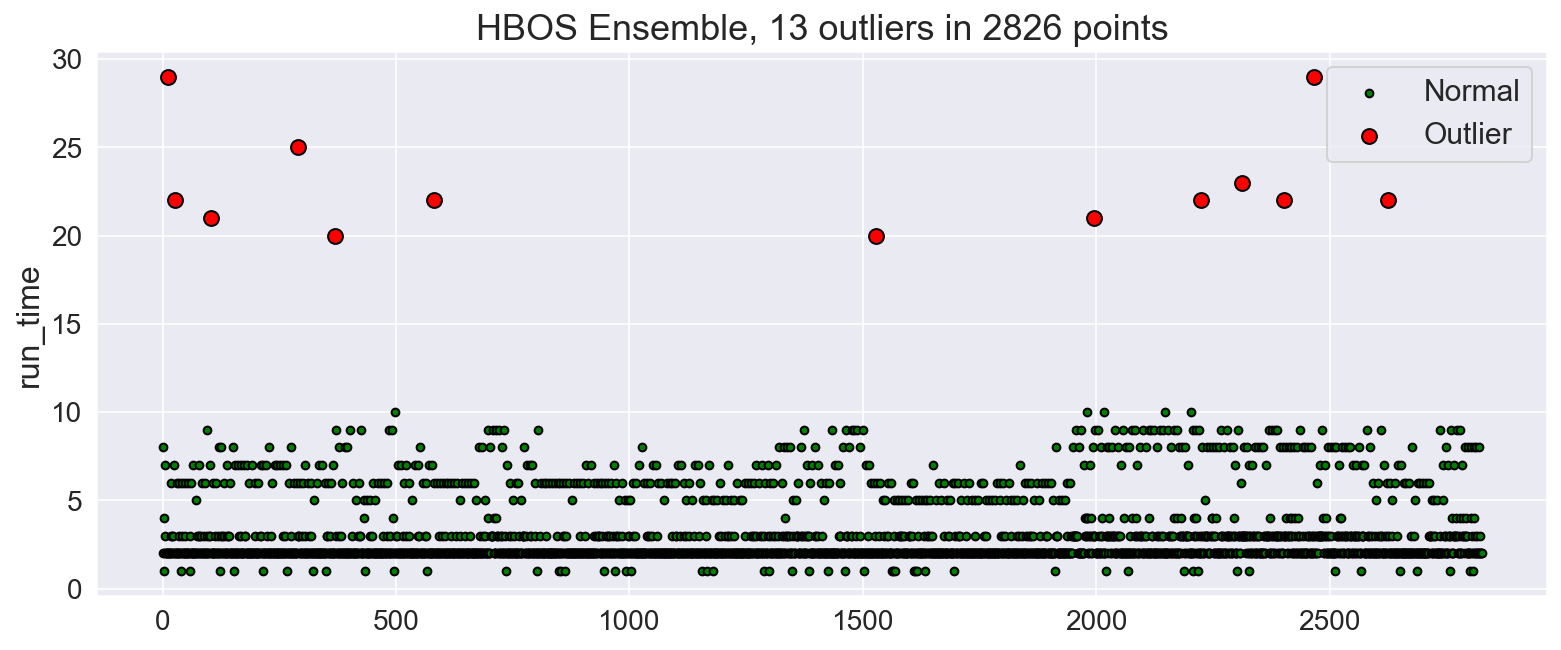

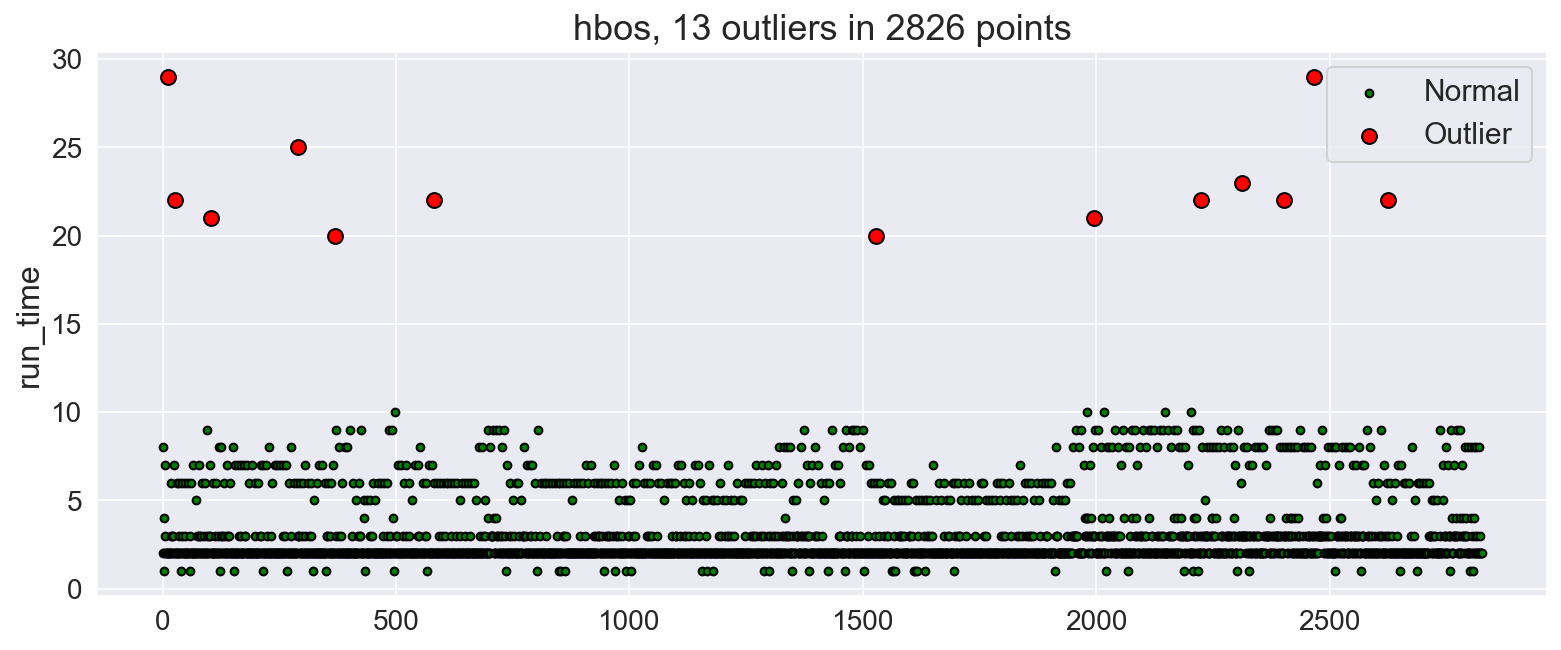

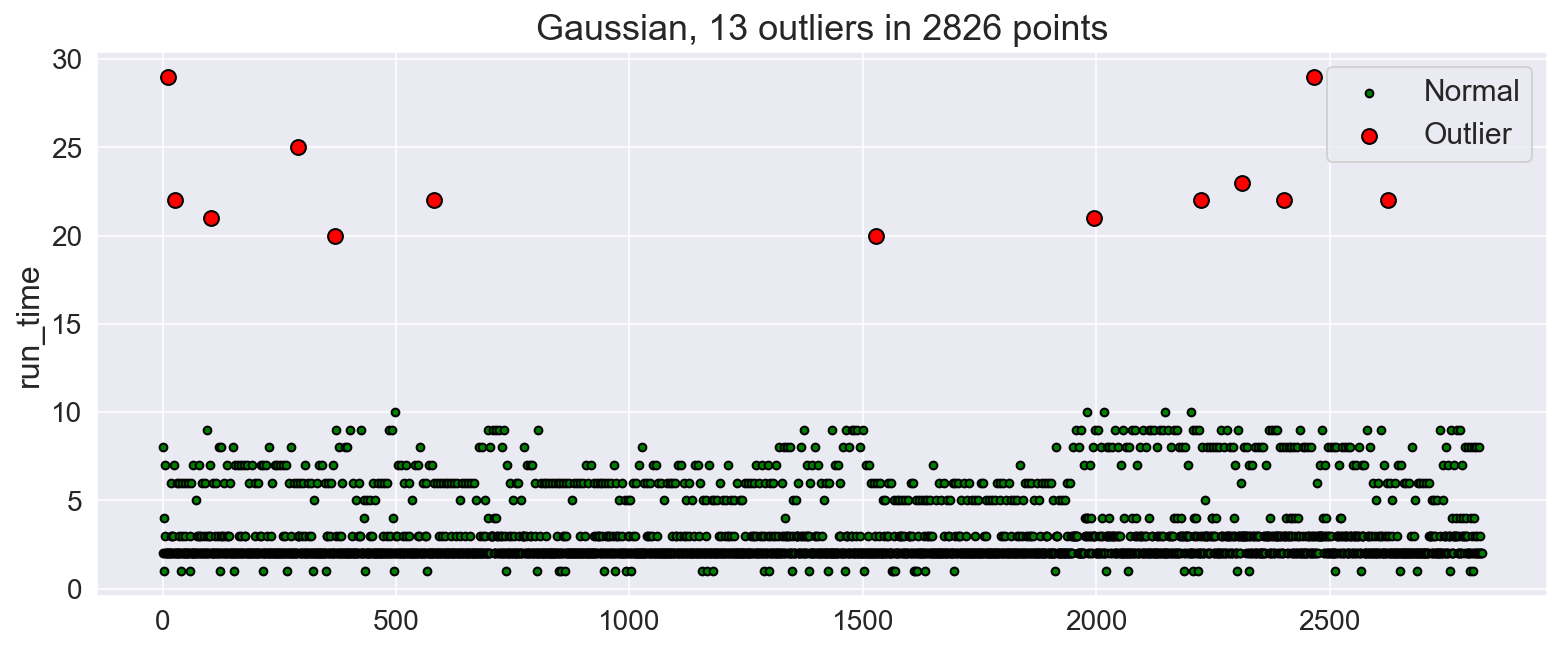

MPI_Comm_size()


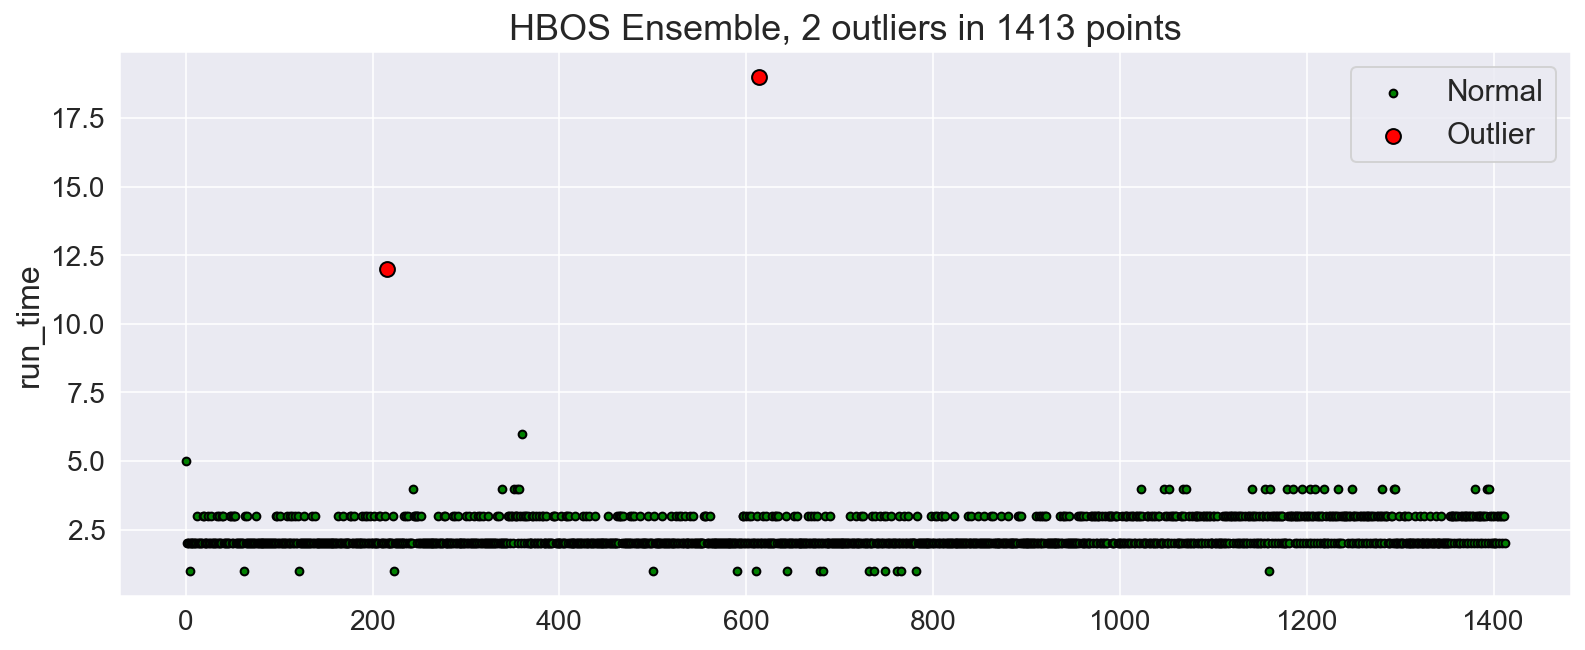

contamination and bins lowered with c=0.001, n_bins=2


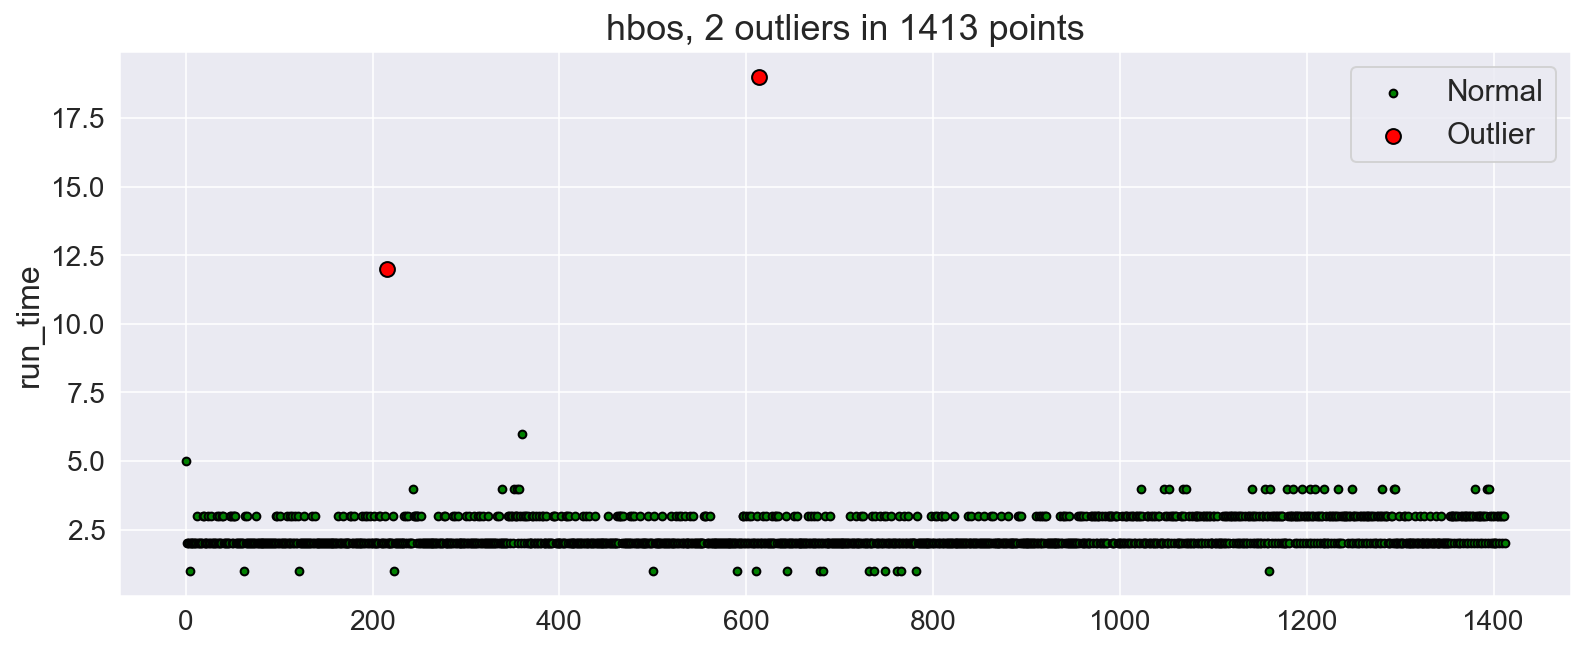

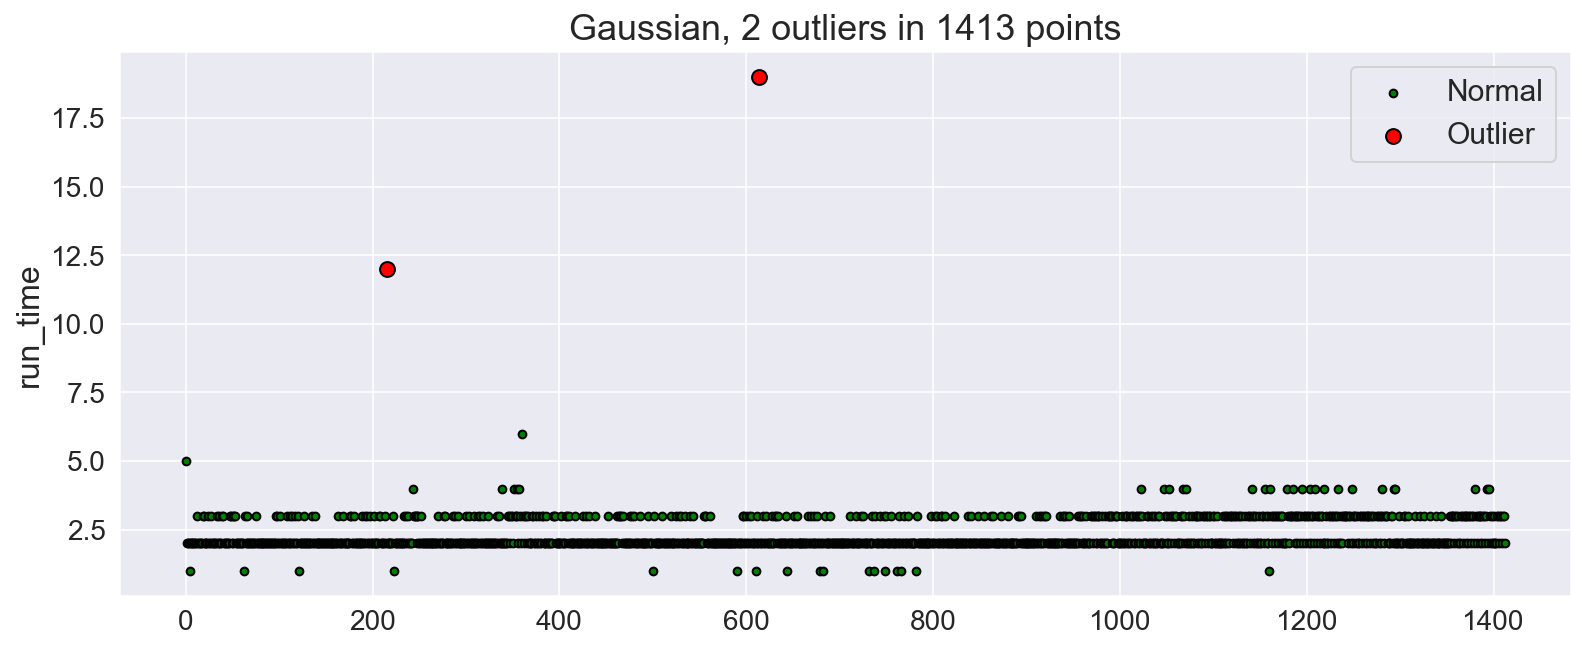

the_function(int)_[{/bld/benchmark_suite/func_multimodal/main.C}_{18,0}]


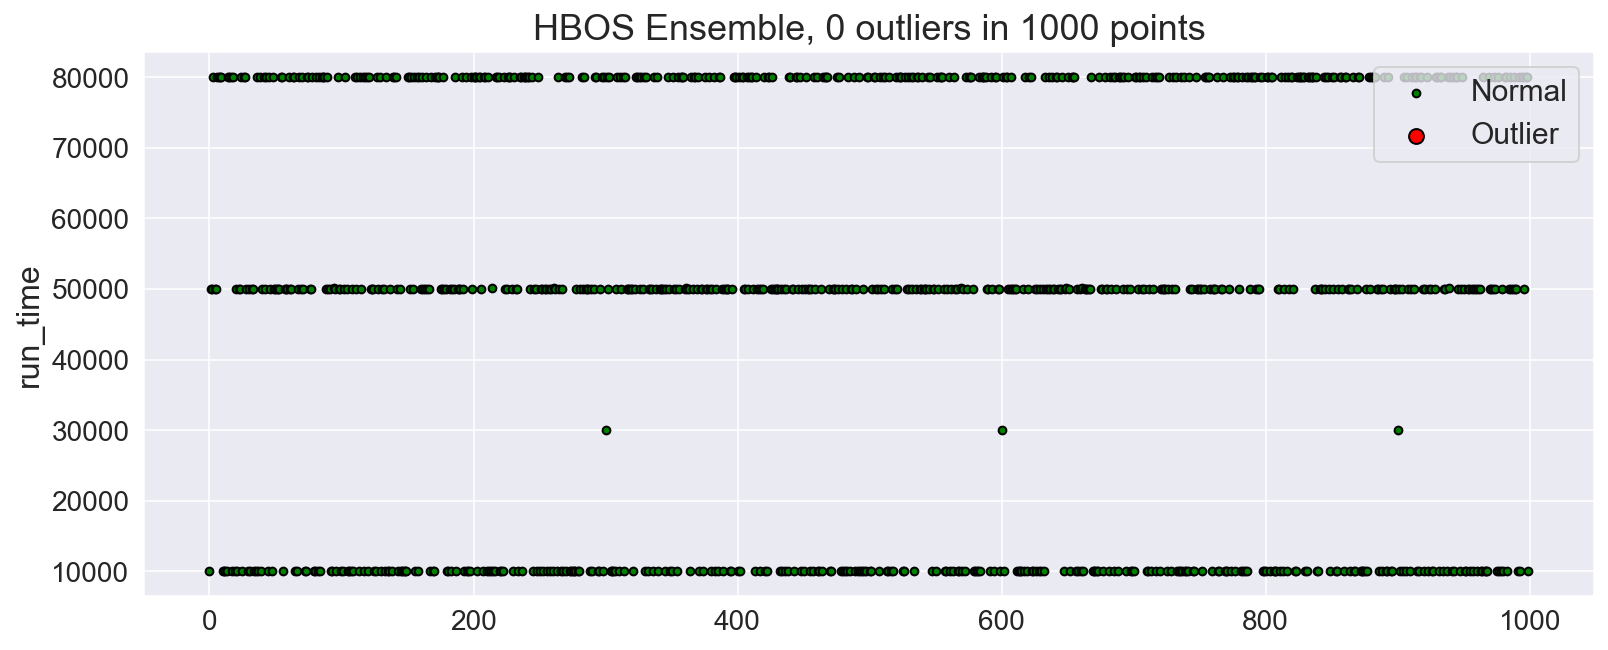

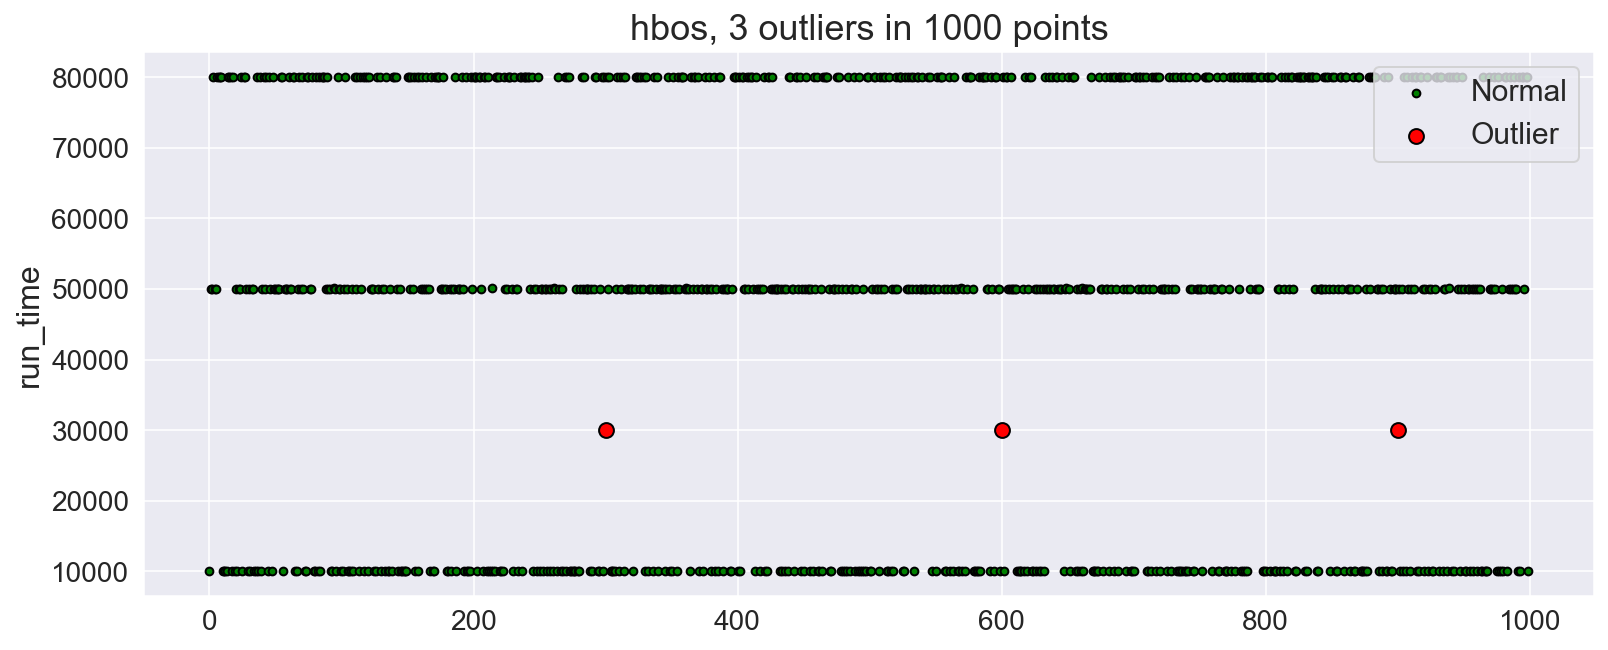

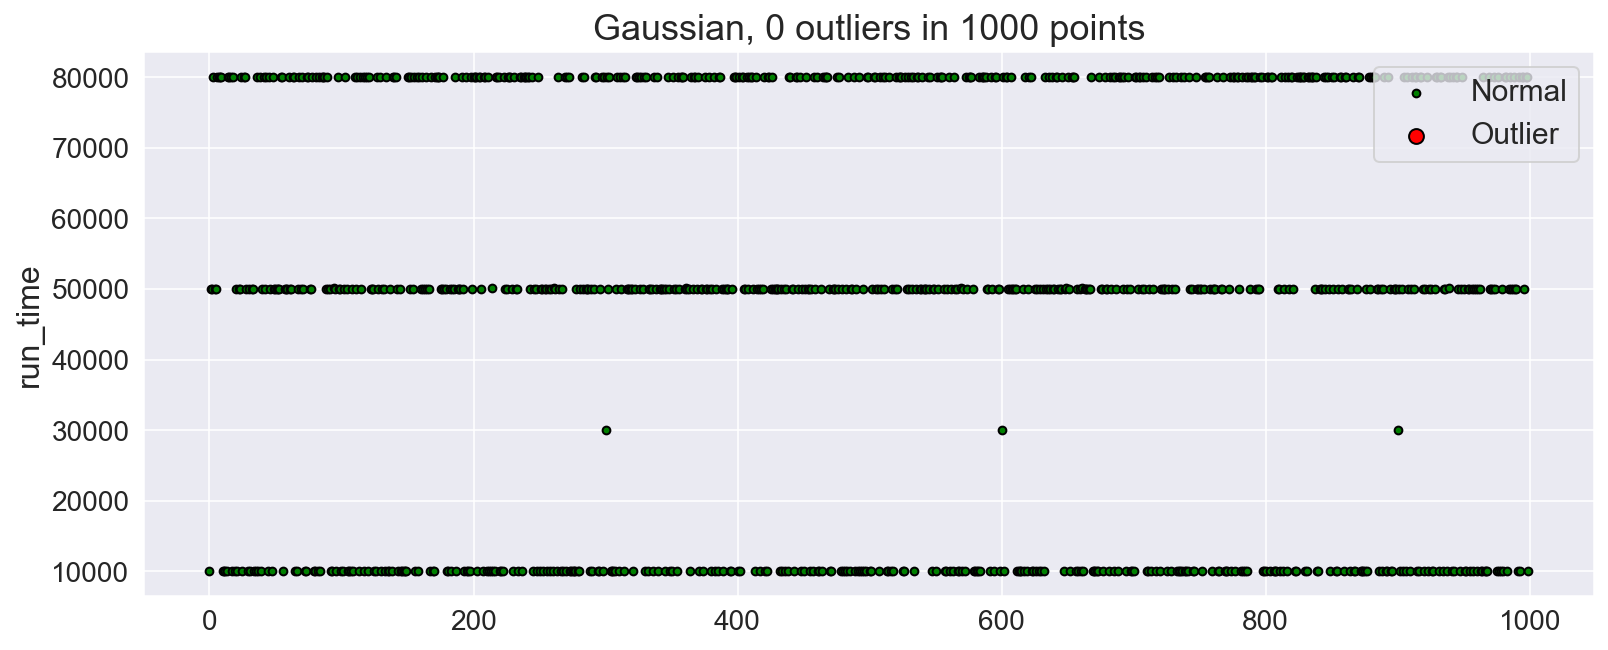

MPI_Gatherv()


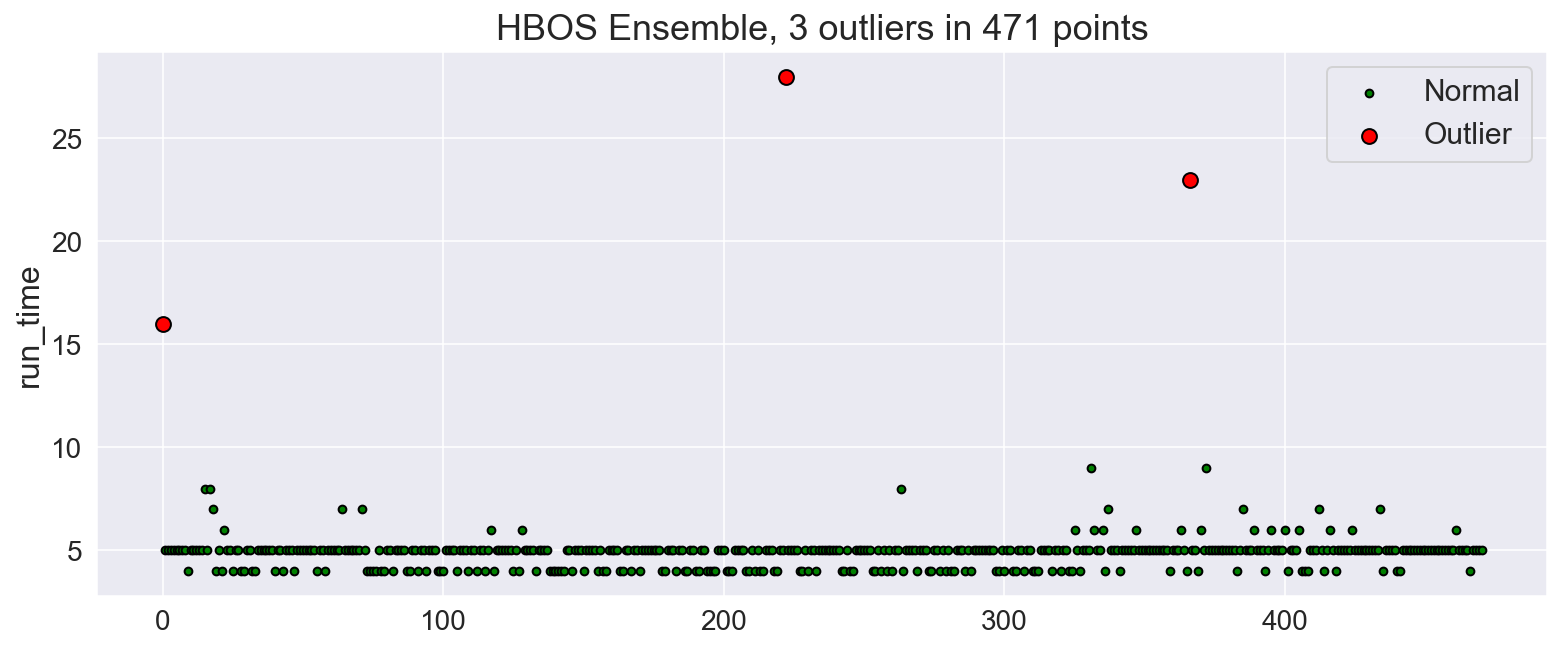

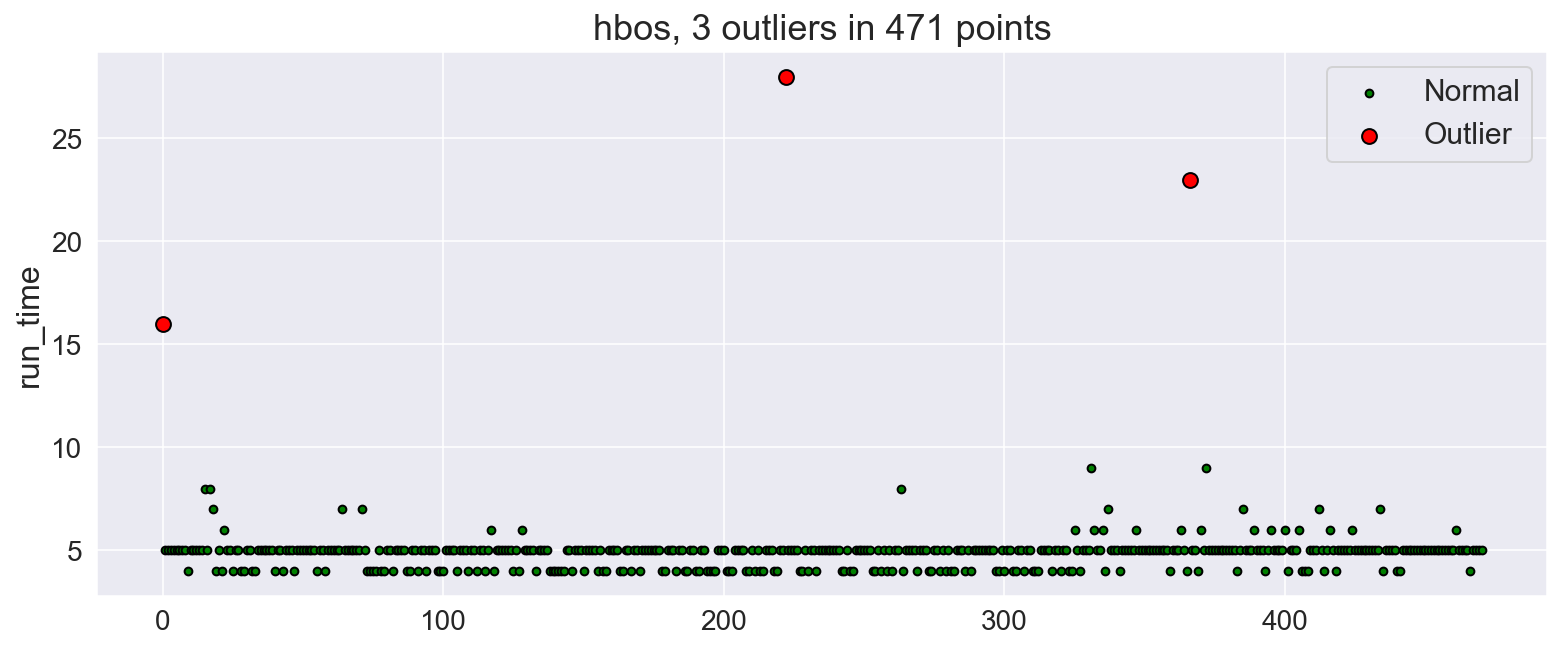

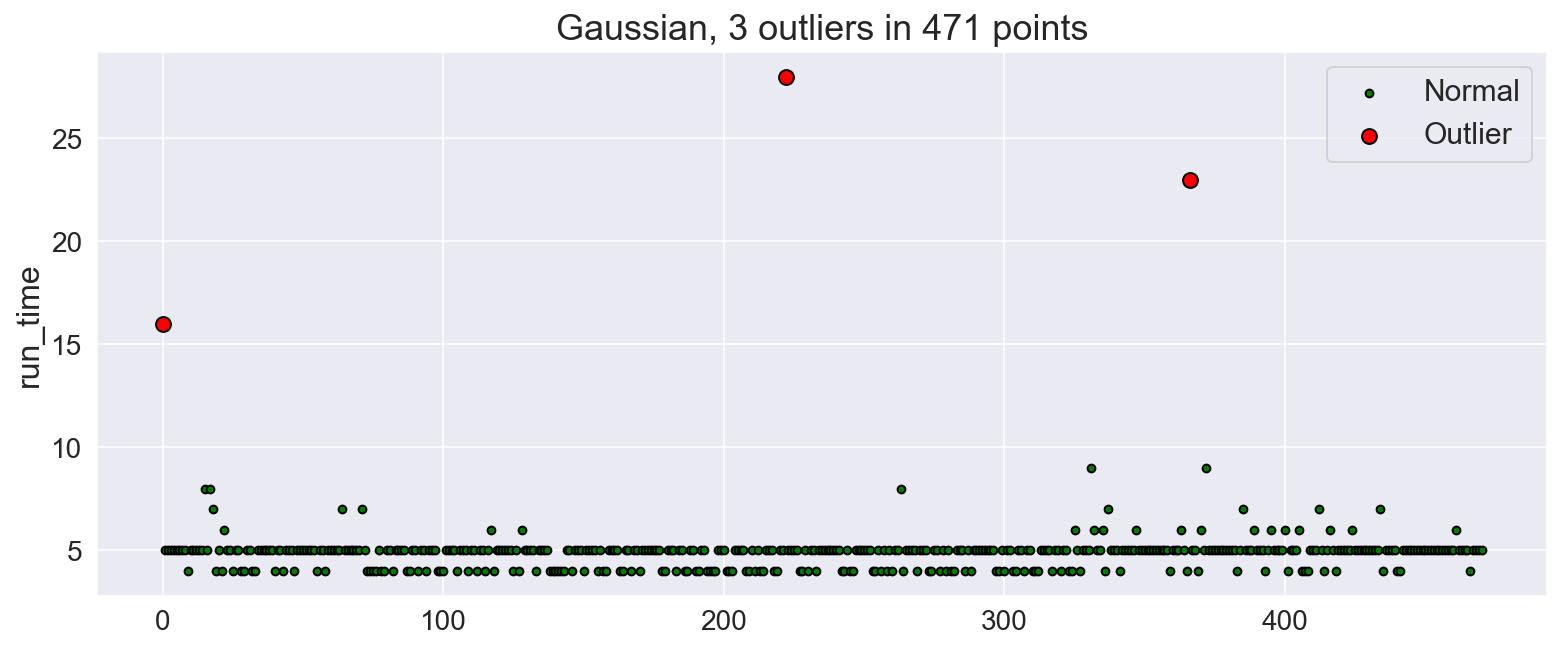

MPI_Gather()


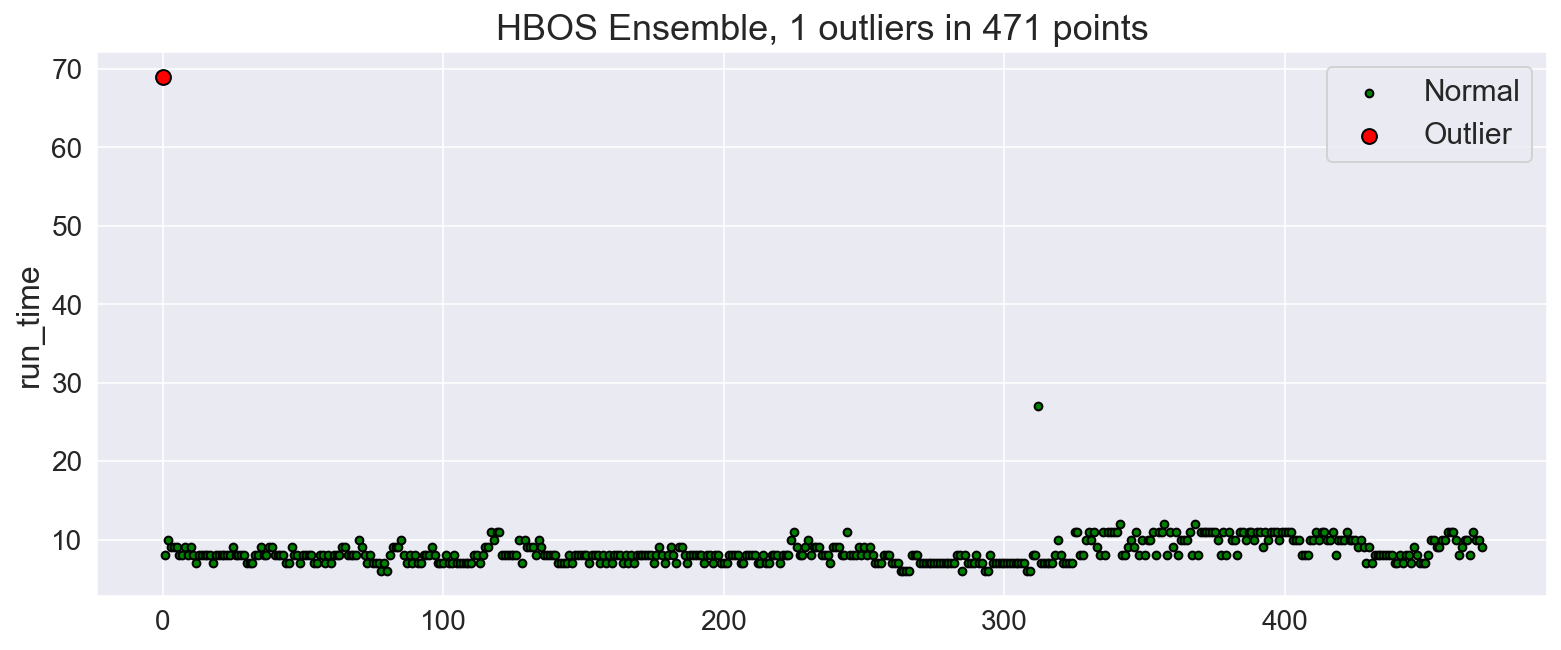

contamination and bins lowered with c=0.001, n_bins=2


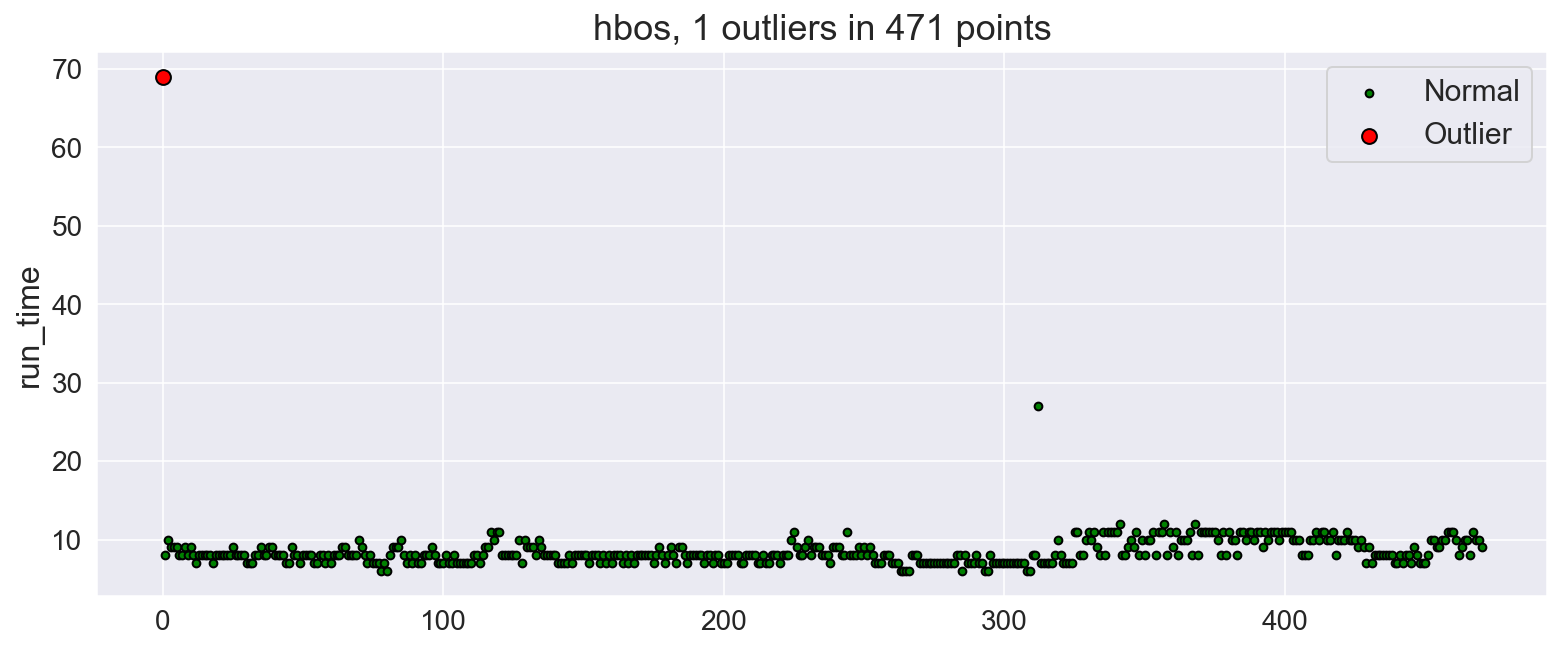

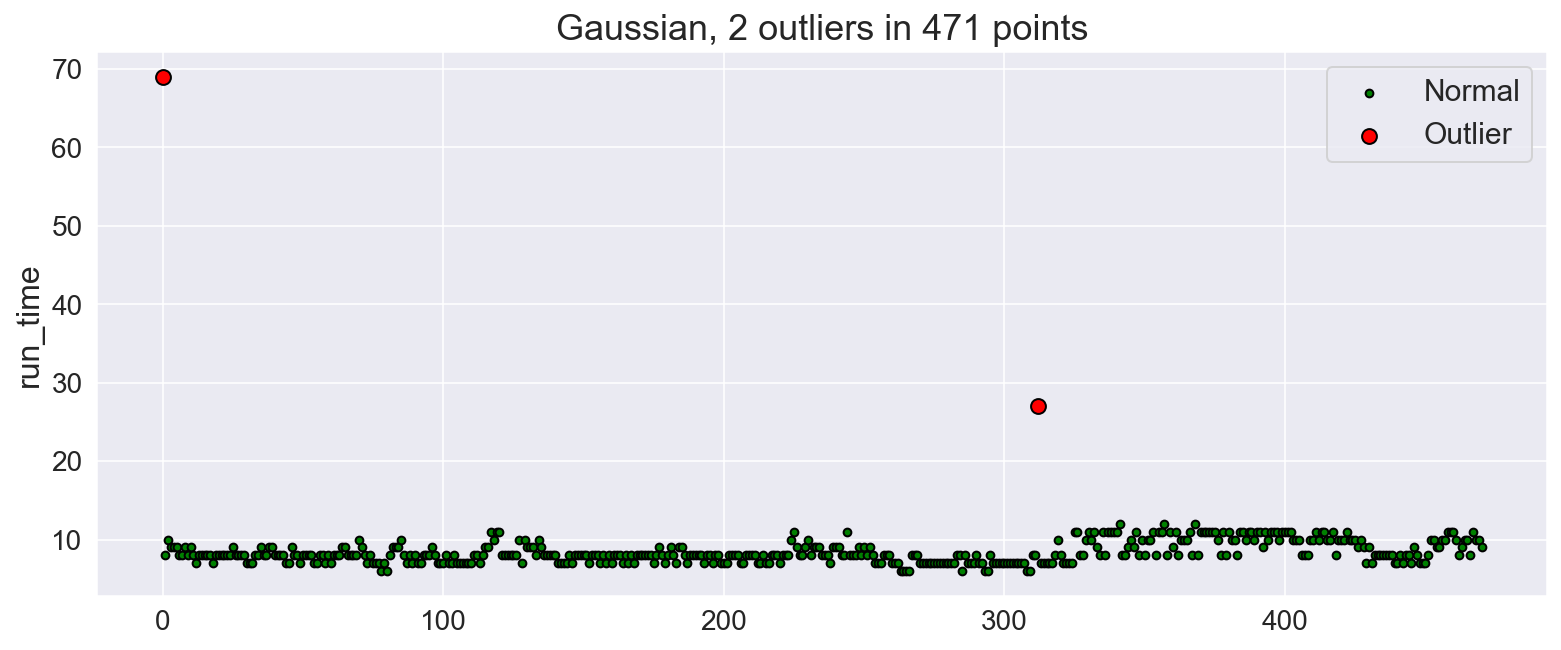

total time used: 3.734675168991089


In [103]:
start = time.time()
for i in range(len(df_freq)): # test 10 random samples
    func_name = df_freq['func_name'].iloc[i]
    sample = dic_to_dataframe(run_time_labeled, func_name)
    print(func_name)
    hbos_ensemble(sample, anomaly_ratio, bins, alpha, percent = 0.4, plot=True);
    hbos(sample, n_bins=4, alpha = 0.1, enforce=False, plot=True);
    moving_gaussian(sample);
end = time.time()
print("total time used: {}".format(end - start))